In [91]:
import gc
import os
import os.path
import time

import matplotlib.pyplot as plt
import numpy as np
from six.moves import cPickle as pickle
from skimage.transform import resize


class MultiDigitSVHNData(object):
    def __init__(self, digit_count=5, input_total_data_count=1, image_size=32):
        self.digit_count = digit_count
        self.image_width = image_size
        self.image_height = image_size
        self.target_digit_num_labels = 10
        self.num_channels = 3

        self.input_total_data_count = input_total_data_count
        self.total_data_count = input_total_data_count  # ds.num_examples
        self.update_data_counts()

        self.train_data = None
        self.train_label_length = None
        self.train_label_digits = None
        self.validation_data = None
        self.validation_label_length = None
        self.validation_label_digits = None
        self.test_data = None
        self.test_label_length = None
        self.test_label_digits = None

    def update_data_counts(self):
        self.train_data_count = int(0.9 * self.total_data_count)
        self.validation_data_count = int(0.05 * self.total_data_count)
        self.test_data_count = self.total_data_count - self.train_data_count - self.validation_data_count

    def print_image(self, image):
        sample_image = image
        plt.figure()
        plt.imshow(sample_image)  # display it
        gc.collect()

    @staticmethod
    def maybe_pickle(digit_count, total_data_count, image_size=54, force=False):
        filename = 'svhn/svhn_' + str(digit_count) + '_' + str(image_size) + '_' + str(total_data_count) + '.pickle'

        if os.path.exists(filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % filename)
            svhn_data = MultiDigitSVHNData.load_pickle(filename)
        else:
            print('Pickling %s.' % filename)
            svhn_data = MultiDigitSVHNData(digit_count=digit_count, input_total_data_count=total_data_count,
                                           image_size=image_size)
            svhn_data.load_data()
            try:
                MultiDigitSVHNData.write_pickle(filename, svhn_data)
            except Exception as e:
                print('Unable to save data to', filename, ':', e)
        return svhn_data

    @staticmethod
    def write_pickle(filename, data):
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

    @staticmethod
    def load_pickle(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

    def reformat_target_length(self, target_length):
        return (np.arange(self.digit_count + 1) == target_length).astype(np.float32)

    def reformat_target_digits(self, target_digits):
        return (np.arange(10) == target_digits).astype(np.float32)

    def load_data(self):
        import random
        random.seed(42)

        from fuel.config_parser import config
        from fuel.datasets.svhn import SVHN
        config.data_path = './svhn/converted'
        ds = SVHN(which_format=1, which_sets=('train', 'test', 'extra'))
        rows = np.array(ds.get_data(state=ds.open(), request=range(0, self.input_total_data_count)))
        rows_len = len(rows)

        new_cnt = 0
        for data_index in range(0, self.input_total_data_count):
            target_image = rows[5][data_index]
            target_image_length = len(rows[1][data_index])
            if target_image_length <= self.digit_count:
                new_cnt += 1
        self.total_data_count = new_cnt
        self.update_data_counts()

        self.total_data = np.zeros((self.total_data_count, self.image_height, self.image_width, self.num_channels))
        self.total_label_length = np.zeros((self.total_data_count, 1, self.digit_count + 1))
        self.total_label_digits = np.zeros((self.total_data_count, self.digit_count, 10))
        print("total_data", self.total_data.shape)
        print("total_label_length", self.total_label_length.shape)
        print("total_label_digits", self.total_label_digits.shape)

        print("start : {}".format(time.strftime("%Y-%m-%dT%H:%M:%S%z")))
        total_data_index = 0
        for data_index in range(0, self.input_total_data_count):
            target_image = rows[5][data_index]
            target_image_length = len(rows[1][data_index])
            top = int(np.min(rows[3][data_index]) * 0.7)
            bottom = int(np.max(rows[0][data_index] + rows[3][data_index]) * 1.3)
            left = int(np.min(rows[2][data_index]) * 0.7)
            right = int(np.max(rows[2][data_index] + rows[4][data_index]) * 1.3)

            if target_image_length <= self.digit_count:
                self.total_label_length[total_data_index] = self.reformat_target_length(target_image_length)

                for digit_index in range(0, target_image_length):
                    self.total_label_digits[total_data_index][digit_index] = self.reformat_target_digits(
                        rows[1][data_index][digit_index][0])

                rand_x = random.randrange(0,11)
                rand_y = random.randrange(0,11)
                for channel_index in range(0, self.num_channels):
                    resized_image = resize(target_image[channel_index][top:bottom + 1, left:right + 1],
                                           output_shape=[self.image_width + 10, self.image_height + 10])
                    resized_image = resized_image[rand_x:self.image_width + rand_x, rand_y:self.image_height + rand_y]
                    for image_height_index in range(0, self.image_height):
                        for image_width_index in range(0, self.image_width):
                            self.total_data[total_data_index][image_height_index][image_width_index][channel_index] = \
                                resized_image[image_height_index][image_width_index]

                total_data_index += 1

        print("end : {}".format(time.strftime("%Y-%m-%dT%H:%M:%S%z")))

        self.train_data = self.total_data[:self.train_data_count]
        self.train_label_length = self.total_label_length[:self.train_data_count]
        self.train_label_digits = self.total_label_digits[:self.train_data_count]
        print("train_data", self.train_data.shape)  # (49000, 140, 28, 1)
        print("train_label_length", self.train_label_length.shape)  # (49000, 1, 6)
        print("train_label_digits", self.train_label_digits.shape)  # (49000, 5, 10)

        self.validation_data = self.total_data[self.train_data_count:self.train_data_count + self.validation_data_count]
        self.validation_label_length = self.total_label_length[
                                       self.train_data_count:self.train_data_count + self.validation_data_count]
        self.validation_label_digits = self.total_label_digits[
                                       self.train_data_count:self.train_data_count + self.validation_data_count]
        print("validation_data", self.validation_data.shape)  # (14000, 140, 28, 1)
        print("validation_label_length", self.validation_label_length.shape)  # (14000, 1, 6)
        print("validation_label_digits", self.validation_label_digits.shape)  # (14000, 5, 10)

        self.test_data = self.total_data[self.train_data_count + self.validation_data_count:]
        self.test_label_length = self.total_label_length[self.train_data_count + self.validation_data_count:]
        self.test_label_digits = self.total_label_digits[self.train_data_count + self.validation_data_count:]
        print("test_data", self.test_data.shape)  # (7000, 140, 28, 1)
        print("test_label_length", self.test_label_length.shape)  # (7000, 1, 6)
        print("test_label_digits", self.test_label_digits.shape)  # (7000, 5, 10)

svhn/svhn_5_54_100.pickle already present - Skipping pickling.
2
(2, 3)


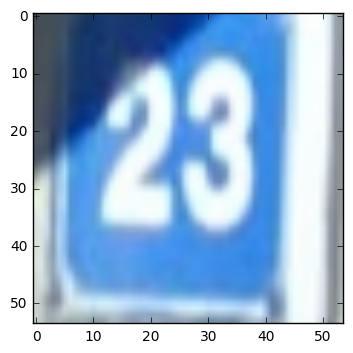

In [93]:
svhn_data = MultiDigitSVHNData.maybe_pickle(digit_count=5, total_data_count=100)
print(np.argmax(svhn_data.train_label_length[1]))
print(np.argmax(svhn_data.train_label_digits[1][0]), np.argmax(svhn_data.train_label_digits[1][1]))
svhn_data.print_image(svhn_data.train_data[1])

svhn/svhn_5_54_1000.pickle already present - Skipping pickling.
2
(2, 3)


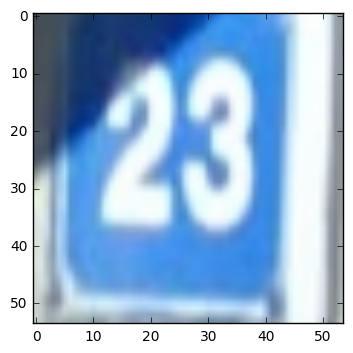

In [95]:
svhn_data = MultiDigitSVHNData.maybe_pickle(digit_count=5, total_data_count=1000)
print(np.argmax(svhn_data.train_label_length[1]))
print(np.argmax(svhn_data.train_label_digits[1][0]), np.argmax(svhn_data.train_label_digits[1][1]))
svhn_data.print_image(svhn_data.train_data[1])

svhn/svhn_5_54_10000.pickle already present - Skipping pickling.
2
(2, 3)


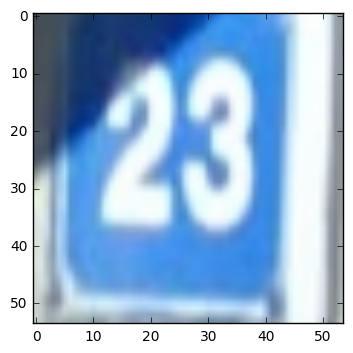

In [97]:
svhn_data = MultiDigitSVHNData.maybe_pickle(digit_count=5, total_data_count=10000)
print(np.argmax(svhn_data.train_label_length[1]))
print(np.argmax(svhn_data.train_label_digits[1][0]), np.argmax(svhn_data.train_label_digits[1][1]))
svhn_data.print_image(svhn_data.train_data[1])

svhn/svhn_5_54_20000.pickle already present - Skipping pickling.
2
(2, 3)


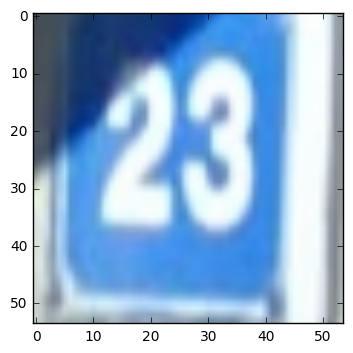

In [102]:
svhn_data = MultiDigitSVHNData.maybe_pickle(digit_count=5, total_data_count=20000)
print(np.argmax(svhn_data.train_label_length[1]))
print(np.argmax(svhn_data.train_label_digits[1][0]), np.argmax(svhn_data.train_label_digits[1][1]))
svhn_data.print_image(svhn_data.train_data[1])

svhn/svhn_5_54_30000.pickle already present - Skipping pickling.
2
(2, 3)


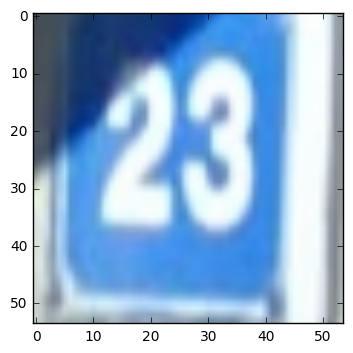

In [103]:
svhn_data = MultiDigitSVHNData.maybe_pickle(digit_count=5, total_data_count=30000)
print(np.argmax(svhn_data.train_label_length[1]))
print(np.argmax(svhn_data.train_label_digits[1][0]), np.argmax(svhn_data.train_label_digits[1][1]))
svhn_data.print_image(svhn_data.train_data[1])

In [100]:
svhn_data = MultiDigitSVHNData.maybe_pickle(digit_count=5, total_data_count=40000)
print(np.argmax(svhn_data.train_label_length[1]))
print(np.argmax(svhn_data.train_label_digits[1][0]), np.argmax(svhn_data.train_label_digits[1][1]))
svhn_data.print_image(svhn_data.train_data[1])

Pickling svhn/svhn_5_54_40000.pickle.
('total_data', (39999, 54, 54, 3))
('total_label_length', (39999, 1, 6))
('total_label_digits', (39999, 5, 10))
start : 2016-11-16T10:13:32+0900


KeyboardInterrupt: 

In [101]:
svhn_data = MultiDigitSVHNData.maybe_pickle(digit_count=5, total_data_count=70000)
print(np.argmax(svhn_data.train_label_length[1]))
print(np.argmax(svhn_data.train_label_digits[1][0]), np.argmax(svhn_data.train_label_digits[1][1]))
svhn_data.print_image(svhn_data.train_data[1])

Pickling svhn/svhn_5_54_70000.pickle.


Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 